# Boosting and AdaBoost

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases [1].

## Table of Contents

1. [Introduction](#intro)
2. [Import Libraries](#libraries)
3. [Sample Dataset](#sample)
4. [Manual Implementation](#manual)
5. [Using Sklearn Library](#sklearn)
6. [Iris Dataset](#iris)
7. [Conclusion](#conclusion)

## 1. Introduction<a id='intro'></a>

## 2. Import Libraries<a id='libraries'></a>

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')
from sklearn.datasets import make_circles
import math as m # to calculate log_e a.k.a. ln 

## 3. Sample Dataset<a id='sample'></a>

The dataset contains two input variables ($x_1$ and $x_2$) and the class output variable with the values 0 and 1. The dataset contains 10 records, 5 that belong to each class.

In [3]:
x1 = [3.64754035, 2.612663842, 2.363359679, 4.932600453, 3.776154753, 
      8.673960793, 5.861599451, 8.984677361, 7.467380954, 4.436284412]
x2 = [2.996793259, 4.459457779, 1.506982189, 1.299008795, 3.157451378, 
      2.122873405, 0.003512817, 1.768161009, 0.187045945, 0.862698005]
y = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

df = pd.DataFrame(zip(x1, x2, y), columns=['x1', 'x2', 'y'])
df

,x1,x2,y
0,3.647540,2.996793,0
1,2.612664,4.459458,0
2,2.363360,1.506982,0
3,4.932600,1.299009,0
4,3.776155,3.157451,0
5,8.673961,2.122873,1
6,5.861599,0.003513,1
7,8.984677,1.768161,1
8,7.467381,0.187046,1
9,4.436284,0.862698,1


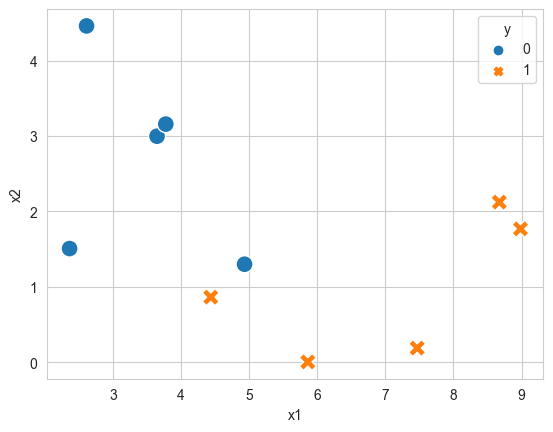

In [4]:
sb.scatterplot(data=df, x='x1', y='x2', hue='y', style='y', s=150)
plt.show()

## 4. Manual Implementation<a id='manual'></a>

$$Missclassification Rate = \frac{\sum_{i=1}^n(w_i \times error_i)}{\sum_{i=1}^nw}$$

In [38]:
def create_model(dataframe, split, feature):
    df_model = dataframe.copy()
    df_model[['Group', 'Prediction', 'Error']] = np.nan
    
    df_model.loc[df[feature] <= split, 'Group'] = 'LEFT'
    df_model.loc[df[feature] > split, 'Group'] = 'RIGHT'
    
    if df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'Group'] == 'RIGHT' and df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'y'] == 0:
        right = 0
        left = 1
    if df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'Group'] == 'RIGHT' and df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'y'] == 1:
        right = 1
        left = 0
    if df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'Group'] == 'LEFT' and df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'y'] == 0:
        right = 1
        left = 0
    if df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'Group'] == 'LEFT' and df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'y'] == 1:
        right = 0
        left = 1

    df_model.loc[df_model['Group'] == 'LEFT', 'Prediction'] = left
    df_model.loc[df_model['Group'] == 'RIGHT', 'Prediction'] = right

    df_model.loc[df_model['y'] == df_model['Prediction'], 'Error'] = 0
    df_model.loc[df_model['y'] != df_model['Prediction'], 'Error'] = 1

    acc = (1 - (df_model['Error'].sum() / len(df))) * 100
    
    return df_model, acc

In [69]:
create_model(df, 2.122873405, 'x2')[0]

,x1,x2,y,Group,Prediction,Error
0,3.647540,2.996793,0,RIGHT,0.0,0.0
1,2.612664,4.459458,0,RIGHT,0.0,0.0
2,2.363360,1.506982,0,LEFT,1.0,1.0
3,4.932600,1.299009,0,LEFT,1.0,1.0
4,3.776155,3.157451,0,RIGHT,0.0,0.0
5,8.673961,2.122873,1,LEFT,1.0,0.0
6,5.861599,0.003513,1,LEFT,1.0,0.0
7,8.984677,1.768161,1,LEFT,1.0,0.0
8,7.467381,0.187046,1,LEFT,1.0,0.0
9,4.436284,0.862698,1,LEFT,1.0,0.0


In [70]:
def train(nr_iter, dataframe):
    df_train = pd.DataFrame(columns=['x1', 'x2', 'y', 'Weight', 'Group', 'Prediction', 
                                     'Error', 'Weighted_Error'])
    sum_weight = []
    sum_error = []
    missclassification = []
    stages = []
    accuracy = []
    splits = [4.932600453, 2.122873405, 0.862698005]
    features = ['x1', 'x2', 'x2']

    for i in range(0, nr_iter):
        result = create_model(dataframe, splits[i], features[i])
        df_temp = result[0]
        acc = result[1]
        if i == 0:
            df_temp['Weight'] = 1 / len(dataframe)
        else:
            for j in range(0, len(df_temp)):
                df_temp.loc[j, 'Weight'] = df_train.loc[j+(i-1), 'Weight'] * np.exp(stages[i-1] * df_train.loc[j+(i-1), 'Weighted_Error'])
            
        df_temp['Weighted_Error'] = df_temp['Weight'] * df_temp['Error']
        # Calculate the sum of weights for the temp dataframe and added to the related list
        sw = df_temp['Weight'].sum() 
        sum_weight.append(sw)
        # Calculate the sum of errors for the temp dataframe and added to the related list
        se = df_temp['Weighted_Error'].sum()
        sum_error.append(se)
        # Calculate the missclassification rate for the temp dataframe and added to the related list
        mc = se / sw
        missclassification.append(mc)
        
        st = m.log(((1-mc)/mc), np.e)
        stages.append(st)
        df_train = pd.concat([df_train, df_temp], ignore_index=True)

        accuracy.append(acc)
    
    return df_train, accuracy

In [72]:
result = train(3, df)
result[0]#.to_csv('compare.csv')

,x1,x2,y,Weight,Group,Prediction,Error,Weighted_Error
0,3.647540,2.996793,0,0.100000,LEFT,0.0,0.0,0.0
1,2.612664,4.459458,0,0.100000,LEFT,0.0,0.0,0.0
2,2.363360,1.506982,0,0.100000,LEFT,0.0,0.0,0.0
3,4.932600,1.299009,0,0.100000,LEFT,0.0,0.0,0.0
4,3.776155,3.157451,0,0.100000,LEFT,0.0,0.0,0.0
5,8.673961,2.122873,1,0.100000,RIGHT,1.0,0.0,0.0
6,5.861599,0.003513,1,0.100000,RIGHT,1.0,0.0,0.0
7,8.984677,1.768161,1,0.100000,RIGHT,1.0,0.0,0.0
8,7.467381,0.187046,1,0.100000,RIGHT,1.0,0.0,0.0
9,4.436284,0.862698,1,0.100000,LEFT,0.0,1.0,0.1


In [73]:
result[1]

[90.0, 80.0, 80.0]

### Prediction

### Another Sample Data

As you can see the proposed algorithm predicts the labels with 100% accuracy score for the sample dataset. We'll create a new dataset using the `make_circles` with 10% of `noise` to spice things up and check the performance of the Bagged Decision Tree algorithm. The dataset contains two input variables ($x_1$ and $x_2$) and the class output variable with the values 0 and 1. The dataset contains 100 records, 50 that belong to each class.

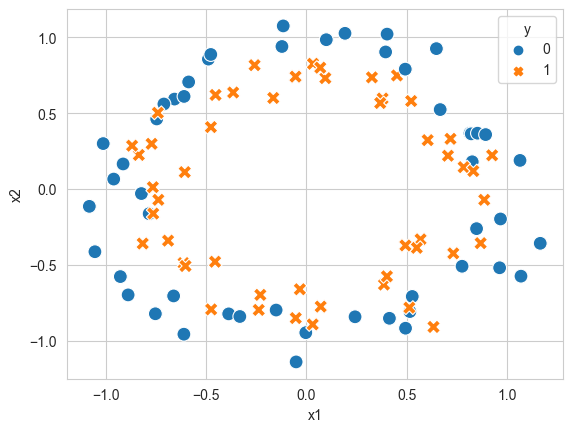

In [7]:
x, y = make_circles(n_samples=100, random_state=101, noise=0.1)

# Turn the features into new dataframe
df_new_sample = pd.DataFrame(zip(x[:,0], x[:,1], y), columns=['x1', 'x2', 'y'])

# Plot the features
sb.scatterplot(data=df_new_sample, x='x1', y='x2', hue='y', style='y', s=100)
plt.show()

### Predicting using new sample dataset

## 5. Using Sklearn Library<a id='sklearn'></a>

We'll use the `AdaBoostClassifier` function from the `sklearn` library and check the accuracy score on the same randomly generated dataset.

## 6. Iris Dataset<a id='iris'></a>

We'll classify the flowers in the wellknown Iris dataset using `AdaBoostClassifier` from `sklearn` library.

## 7. Conclusion<a id='conclusion'></a>

Overall, AdaBoost is a powerful and flexible algorithm that can be applied to a wide range of problems, and has been shown to be highly effective in practice.

## References
---

[1] [sklearn.ensemble.AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)